# Анализ данных и кластеризация покупателей.

### Контекст
##### Набор данных содержит все транзакции произошедшие с 01/12/2010 по 09/12/2011 у Британской компании продающей подарки. Клиенты - оптовики.
### Бизнес-цель
##### Мы будем использовать международный набор данных для розничной торговли онлайн, чтобы построить RFM-кластер и выбрать лучший набор клиентов, на которых должна ориентироваться компания.


### Переменные:

InvoiceNo - номер счёта

StockCode - торговый код

Description - описание товара

Quantity - количество

InvoiceDate - дата выставления счёта

UnitPrice - цена товара

CustomerID - ID покупателя

Country - страна

In [2]:
!pip install patool
import patoolib
patoolib.extract_archive("../data/OnlineRetail.rar", outdir="../data/")

import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore') # отключит предупреждения Anaconda
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' # для чётких графиков в svg

import sklearn
from sklearn.preprocessing import StandardScaler # приближение значений к единице
from sklearn.cluster import KMeans # метод ближайших соседей для класстеризации
from sklearn.metrics import silhouette_score # силуэт - внут. метрика, значения будут в [-1, 1]

from scipy import stats
from scipy.cluster.hierarchy import linkage # выполняет иерархическую класстеризацию
from scipy.cluster.hierarchy import cut_tree # обрубает лишние листья в дереве
from pylab import rcParams
rcParams['figure.figsize'] = 8,5 # увлеличить размер графиков

patool: Extracting ../data/OnlineRetail.rar ...
patool: running "C:\Program Files\WinRAR\rar.EXE" x -- C:\Users\Frees\DataScience\Analysys\Clustering\data\OnlineRetail.rar
patool:     with cwd=../data/
patool: ... ../data/OnlineRetail.rar extracted to `../data/'.


In [3]:
# Считывание данных и вывод нескольких строк.
df = pd.read_csv('../data/OnlineRetail.csv', encoding = "ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
# Размер данных.
df.shape

(541909, 8)

In [5]:
# Столбцы данных.
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
# Краткая информация по переменным.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# Описание числовых переменных.
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# Количество переменных со значением null
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
# Уберем строки где нет значения null
df = df.dropna()
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
# Распределение по странам.
df['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [11]:
# В среднем покупают:
df['Quantity'].mean()

12.06130339774205

In [12]:
# Средняя цена:
df['UnitPrice'].mean()

3.4604710185298773

In [13]:
# Находим случайные выбросы
print(df['Quantity'].max())
print(df['Quantity'].min())

80995
-80995


In [14]:
# Количество уникальных значений
df.nunique()

InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64

In [15]:
# Преобразование строки InvoiceDate в формат Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 406829, dtype: datetime64[ns]

In [16]:
# Заменяем символы кода в число, т.е. 3565A -> 356510
unique_list = []
for string in df['StockCode']:
    for char in string:
        if char not in unique_list:
            unique_list.append(char)
print(len(unique_list))
unique_list.sort()

35


In [17]:
mapping = {char: str(i) for i, char in enumerate(unique_list[1:])}
mapping.update({' ': "50"})
len(mapping)

35

In [18]:
df['StockCode'] = df['StockCode'].replace(to_replace=mapping, regex=True)

In [19]:
# изменяем тип object на float64
df['StockCode'] = df['StockCode'].astype('float64')

In [20]:
# Description можно убрать
df = df.drop(['Description'], axis=1)

In [21]:
# тоже самое и для номера
unique_list = []
for string in df['InvoiceNo']:
    for char in string:
        if char not in unique_list:
            unique_list.append(char)
print(len(unique_list))
unique_list.sort()

11


In [22]:
mapping = {char: str(i) for i, char in enumerate(unique_list)}
len(mapping)

11

In [23]:
df['InvoiceNo'] = df['InvoiceNo'].replace(to_replace=mapping, regex=True)

In [24]:
df['InvoiceNo'] = df.InvoiceNo.astype('float64')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  float64       
 1   StockCode    406829 non-null  float64       
 2   Quantity     406829 non-null  int64         
 3   InvoiceDate  406829 non-null  datetime64[ns]
 4   UnitPrice    406829 non-null  float64       
 5   CustomerID   406829 non-null  float64       
 6   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 24.8+ MB


In [26]:
np.random.seed(seed=42)
# Добавим 3 переменные, используя модель RFM(давность, частота, деньги))
#R (Recency(Давность)): Количество дней с последнего заказа
#F (Frequency(Частота)): Количество транзакций
#M (Monetary(Деньги)): Общая выручка

In [27]:
# Полученные  деньги с заказа
df['amount'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365.0,8512310.0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365.0,71053.0,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365.0,8440611.0,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365.0,8402916.0,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365.0,8402914.0,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [28]:
# Выручка для каждого клиента
grouped_df = df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [29]:
# Количество транзакций у каждого клиента
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
# Соединяем в один датасет
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [30]:
# Разница между последним заказом и заказом из данных
df['diff'] = max(df['InvoiceDate']) - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365.0,8512310.0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365.0,71053.0,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365.0,8440611.0,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365.0,8402916.0,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365.0,8402914.0,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [31]:
# Давность сделки
last_purchase = df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [32]:
# Соединяем в ещё больший датасет
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [33]:
# Только количество дней
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


<AxesSubplot:xlabel='recency'>

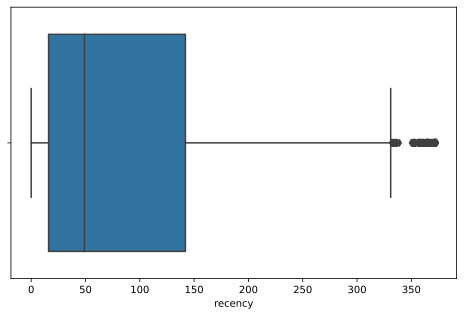

In [34]:
# Посмотрим и уберём выбросы
sns.boxplot(grouped_df['recency'])

In [35]:
# Убираем выбросы у amount
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# Убираем выбросы у recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# Убираем выбросы у frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

In [36]:
# Приближаем значения к единице
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [37]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [38]:
# модель со случайным k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [39]:
kmeans.labels_

array([0, 3, 2, ..., 0, 2, 2])

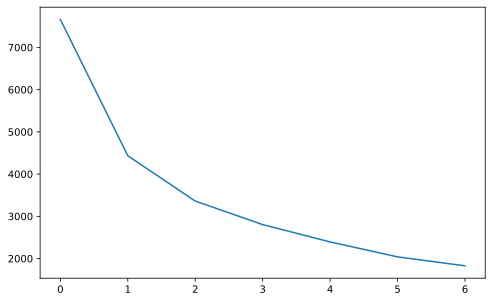

In [40]:
# Определим наилучшее количество кластеров
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# График для понимания качества модели при различном количестве кластеров
plt.plot(ssd)

In [41]:
# анализ силуэта(метрики кластеринга)
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.541842117113117
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4776896767524438
For n_clusters=5, the silhouette score is 0.46613075550600325
For n_clusters=6, the silhouette score is 0.4170584389874765
For n_clusters=7, the silhouette score is 0.415966062047432
For n_clusters=8, the silhouette score is 0.4079520906074672


In [42]:
# Финальная модель с k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [43]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [44]:
# Присвоим значения
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

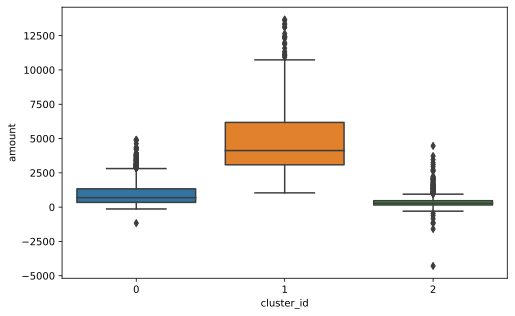

In [45]:
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

In [46]:
# Используем иерархическую полную класстеризацию.
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
grouped_df['cluster_labels'] = cluster_labels

In [47]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

<AxesSubplot:xlabel='cluster_labels', ylabel='recency'>

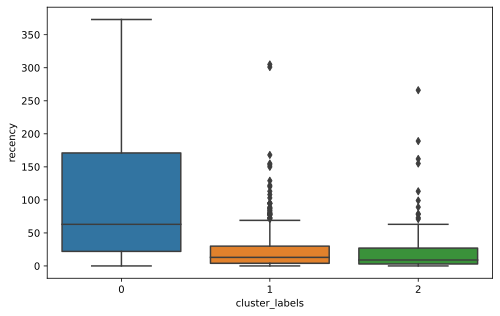

In [48]:
# График по давности
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

<AxesSubplot:xlabel='cluster_labels', ylabel='frequency'>

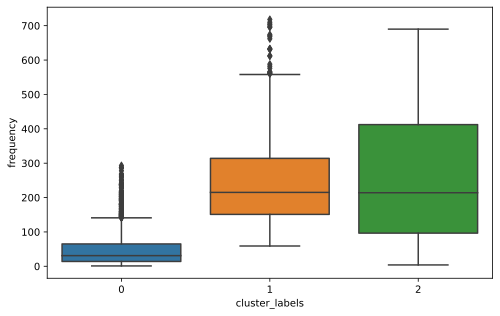

In [49]:
# График по частоте
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

<AxesSubplot:xlabel='cluster_labels', ylabel='amount'>

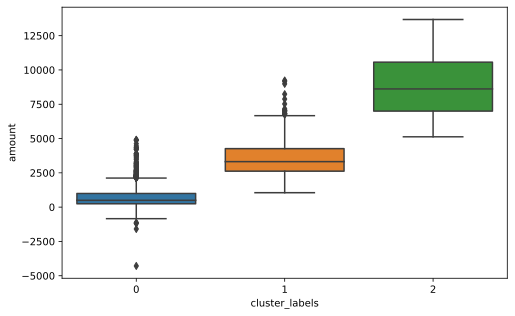

In [50]:
# График по деньгам
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)

In [51]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0


### Вывод
С помощью RFM-анализа можно судить о типе маркетинга, который следует использовать для нацеливания на клиентские сегменты и для перемещения их между сегментами.

Частота и денежные значения расчитывают пожизненную ценность клиента (CLV); Новизна может показать вернётся ли клиент скова.

Получили 3 кластера где:

2-Лучший покупатель, т.е высокая лояльность, большое кол-во покупок и их частота

1-Пассивный клиент - нечастый клиент с низкой суммой покупок и их частотой

0-Потенциальный покупатель: покупатель недавно совершил покупку несколько раз